In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy import optimize

In [2]:
from phase_scan import PhaseScan

In [4]:
decimation_data_comercial = pd.read_csv("Decimation.csv")
# decimation_data_mmi = pd.read_csv("Decimation_mmi.csv")

# DC Values

## Comercial Coupler

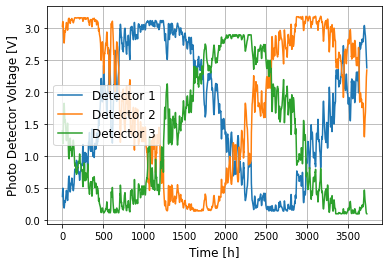

In [5]:
time = np.arange(len(decimation_data_comercial["DC CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_comercial[f"DC CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## MMI Coupler

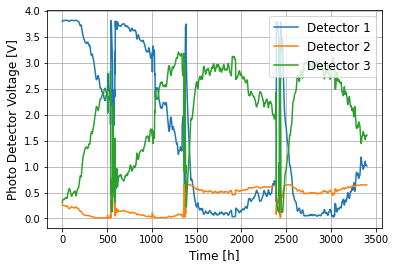

In [5]:
time = np.arange(len(decimation_data_mmi["DC CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_mmi[f"DC CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

# RMS Values

## Comercial Coupler

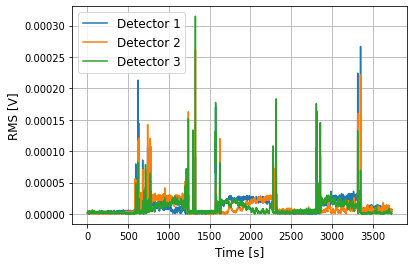

In [6]:
time = np.arange(len(decimation_data_comercial["RMS CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_comercial[f"RMS CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## MMI Coupler

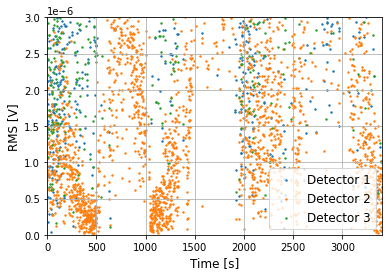

In [7]:
time = np.arange(len(decimation_data_mmi["RMS CH1"]))
for channel in range(1, 4):
    plt.scatter(time, decimation_data_mmi[f"RMS CH{channel}"] * 10, label=f"Detector {channel}", s=2)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.axis([0, len(time), 0, 3e-6])
plt.legend(fontsize=12)
plt.show()

# Response Phases

## Comercial Coupler

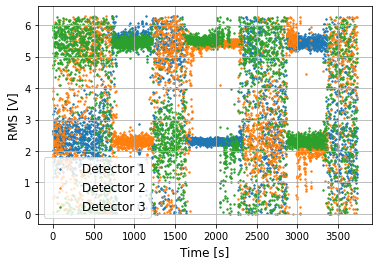

In [8]:
time = np.arange(len(decimation_data_comercial["Response Phase CH1"]))
for channel in range(1, 4):
    data = decimation_data_comercial[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_comercial[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    plt.scatter(time, data, label=f"Detector {channel}", s=2)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [9]:
response_phase_comercial = []
for channel in range(1, 4):
    data = decimation_data_comercial[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_comercial[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    response_phase_comercial.append(np.mean(data[750:1000]))
response_phase_comercial = np.array(response_phase_comercial)
response_phase_comercial

array([5.41991185, 2.3311673 , 5.26887553])

In [10]:
response_phase_comercial[1] += np.pi
response_phase_comercial

array([5.41991185, 5.47275996, 5.26887553])

## MMI Coupler

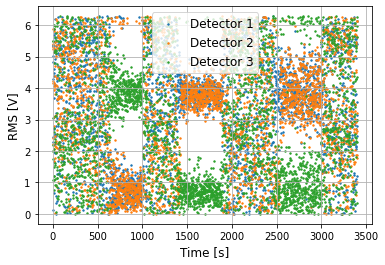

In [11]:
time = np.arange(len(decimation_data_mmi["Response Phase CH1"]))
for channel in range(1, 4):
    data = decimation_data_mmi[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_mmi[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    plt.scatter(time, data, label=f"Detector {channel}", s=2)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [12]:
response_phase_mmi = []
for channel in range(1, 4):
    data = decimation_data_mmi[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_mmi[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    response_phase_mmi.append(np.mean(data[1500:1700]))
response_phase_mmi = np.array(response_phase_mmi)
response_phase_mmi

array([3.85469237, 3.79878346, 0.72470109])

In [13]:
response_phase_mmi = np.array(response_phase_mmi)
response_phase_mmi[2] += np.pi
response_phase_mmi

array([3.85469237, 3.79878346, 3.86629375])

# Interferometric Phase

In [42]:
def detector_1(intensity, detector, i):
    phi = phases[i]
    return lambda x: (np.cos(phi - x) - intensity[detector]) ** 2

def detector_2(intensity, detector):
    phi = 2 * np.pi - np.arccos(intensity[0])
    return lambda x: (np.cos(phi - x) - intensity[detector]) ** 2

def detector_1_df(intensity, detector, i):
    phi = phases[i]
    return lambda x: 2 * (np.cos(phi - x) - intensity[detector]) * np.sin(phi - x)

def detector_2_df(intensity, detector):
    phi = 2 * np.pi - np.arccos(intensity[0])
    return lambda x: 2 * (np.cos(phi - x) - intensity[detector]) * np.sin(phi - x)


In [15]:
def detector(intensity):
    return lambda x: (np.cos(x) - intensity[0]) ** 2 + (np.cos(x - 1.863) - intensity[1]) ** 2 + (np.cos(x - 3.769) - intensity[2]) ** 2

In [37]:
min_values = []
max_values = []
t = 0
results_detector_1 = []
phases_comercial_coupler = []
results_detector_2 = []
last_time = 0

data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()
phases = []
bnds_1 = ((0, np.pi),)
bnds_2 = ((np.pi, 2 * np.pi),)
for i in range(len(data)):
    signal = np.array([decimation_data_mmi["DC CH1"][i], decimation_data_mmi["DC CH2"][i], decimation_data_mmi["DC CH3"][i]])
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res1 = optimize.fminbound(detector(signal), 0, 2 * np.pi)
    #res2 = minimize(detector(signal), x0=np.array([2 * np.pi - np.arccos(signal[0])]), bounds=bnds_2).x[0]
    #if abs(detector(signal)(res1)) < abs(detector(signal)(res2)):
    #    phases.append(res1)
    #else:
    #    phases.append(res2)
    phases.append(res1)
phases = np.array(phases)

In [32]:
phases

array([0.11355799, 0.06738417, 0.06062555, ..., 2.08793616, 2.0889092 ,
       2.0889092 ])

## Comercial Coupler

In [18]:
min_values = []
max_values = []
t = 0
results_detector_1 = []
phases_comercial_coupler = []
results_detector_2 = []
last_time = 0

data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

for i in range(len(data)):
    signal = np.array([decimation_data_mmi["DC CH1"][i], decimation_data_mmi["DC CH2"][i], decimation_data_mmi["DC CH3"][i]])
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res_1 = minimize(detector_1(signal, 1, i), x0=np.array([2.154]), jac=detector_1_df(signal, 1)).x[0]
    res_2 = minimize(detector_2(signal, 1, i), x0=np.array([2.154]), jac=detector_2_df(signal, 1, i)).x[0]
    if np.abs(res_1 - 2.154) < np.abs(res_2 - 2.154):
        results_detector_1.append(res_1)
        phases_comercial_coupler.append(np.arccos(signal[0]))
        res_1 = minimize(detector_1(signal, 2, i), x0=np.array([4.223]), jac=detector_1_df(signal, 2, i)).x[0]
        results_detector_2.append(res_1)
    else:
        results_detector_1.append(res_2)
        phases_comercial_coupler.append(2 * np.pi - np.arccos(signal[0]))
        res_2 = minimize(detector_2(signal, 2), x0=np.array([4.223]), jac=detector_2_df(signal, 2)).x[0]
        results_detector_2.append(res_2)
    t += 1

In [19]:
output_phase_1_comercial_coupler = np.array(results_detector_1)
output_phase_2_comercial_coupler = np.array(results_detector_2)

In [30]:
%matplotlib tk
plt.scatter(range(len(phases)), phases, label="Interferometrio Phase", s=2, color="#64AA9A")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel(r"$\varphi$ [rad]", fontsize=12)
plt.grid()
plt.show()

## MMI Coupler

In [57]:
min_values = []
max_values = []
t = 0
results_detector_1 = []
phases_mmi_coupler = []
results_detector_2 = []
last_time = 0

data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

for i in range(len(data)):
    signal = np.array([decimation_data_mmi["DC CH1"][i], decimation_data_mmi["DC CH2"][i], decimation_data_mmi["DC CH3"][i]])
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res_1 = minimize(detector_1(signal, 1, i), x0=np.array([1.89]), jac=detector_1_df(signal, 1, i)).x[0]
    res_2 = minimize(detector_1(signal, 2, i), x0=np.array([3.769]), jac=detector_1_df(signal, 2, i)).x[0]
    results_detector_1.append(res_1)
    results_detector_2.append(res_2)

In [52]:
results_detector_1

[1.8711509132462747,
 1.8726844875650583,
 1.8728173463462012,
 1.8729762756496942,
 1.8730861191862644,
 1.8731611669465758,
 1.8732267200121675,
 1.8732981526531614,
 1.8733293482556888,
 1.8733481493913264,
 1.8733318444943952,
 1.8733223477224774,
 1.8733006424367262,
 1.873273782217085,
 1.8732480219998076,
 1.8732150748013918,
 1.873193782421113,
 1.8731819658717834,
 1.8731809453685773,
 1.8731712077697156,
 1.8731701209073963,
 1.8731952789990738,
 1.8732194695702329,
 1.8732702207601586,
 1.8733332803348755,
 1.873406163177961,
 1.8734939050515125,
 1.8735854649217176,
 1.8736586579778516,
 1.873732713943741,
 1.8738014990502958,
 1.873867648062367,
 1.8739355103222206,
 1.873986946573133,
 1.8740386891282164,
 1.8740571215877022,
 1.8741041112106105,
 1.8741099286865035,
 1.8741008167846034,
 1.874099079113281,
 1.8740980758857126,
 1.874070835849358,
 1.8740101128376787,
 1.8739578091134776,
 1.8738053527760572,
 1.873671525472659,
 1.8736638273634767,
 1.8735945895143828,
 

In [53]:
output_phase_1_mmi_coupler = np.array(results_detector_1)
output_phase_2_mmi_coupler = np.array(results_detector_2)

In [54]:
plt.scatter(range(len(phases)), phases, label="Interferometrio Phase", s=2, color="#64AA9A")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel(r"$\varphi$ [rad]", fontsize=12)
plt.grid()
plt.show()

# PTI Signal

In [24]:
def calculate_pti_signal(root_mean_square: np.array, lock_in_phase: np.array, output_phases: np.array, phases: np.array,
                         phase_scan: PhaseScan, response_phases: np.array) -> np.array:
    pti_signal = np.zeros(shape=phase_scan.scaled_signals.shape).T
    weight = np.zeros(shape=phase_scan.scaled_signals.shape).T
    for channel in range(3):
        sign = np.sin(phases - output_phases[channel]) > 0
        reponse_phase = response_phases[channel]
        demoudalted_signal = root_mean_square[channel] * np.cos(lock_in_phase[channel] - reponse_phase)
        pti_signal += demoudalted_signal * sign
        weight += (PhaseScan.max_intensities[channel] - PhaseScan.min_intensities[channel]) / 2 * np.abs(np.sin(phases - output_phases[channel]))
    pti = np.sum(-pti_signal, axis=0) / np.sum(weight, axis=0)
    scaling = sum([PhaseScan.max_intensities[channel] - PhaseScan.min_intensities[channel] / 2 for channel in range(3)])
    return pti * 1e6

## Comercial Coupler

In [25]:
data = np.array([decimation_data_comercial["DC CH1"], decimation_data_comercial["DC CH2"], decimation_data_comercial["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

pti_comercial = calculate_pti_signal(root_mean_square=np.array([decimation_data_comercial[f"RMS CH{i}"] for i in range(1, 4)]),
                            lock_in_phase=np.array([decimation_data_comercial[f"Response Phase CH{i}"] for i in range(1, 4)]),
                            phases=phases_comercial_coupler, phase_scan=phase_scan, response_phases=np.array(response_phase_comercial),
                            output_phases=np.array([0, 2.154, 4.223]))
#pti_comercial = pti_comercial / np.sum(data, axis=1)
pti_mean_comercial = np.mean(np.array(pti_comercial).reshape(-1, 8), axis=1)
time_mean_comercial = np.arange(pti_mean_comercial.size)
time_mean_comercial *= 8

ValueError: operands could not be broadcast together with shapes (3736,) (3402,) 

In [ ]:
plt.plot(time_mean_comercial, -pti_mean_comercial, label="Low Pass Filtered (13 s Mean)")
plt.scatter(range(len(pti_comercial)), -pti_comercial, color="orange", s=2, label="1 s Data")
plt.grid()
plt.axis([0, len(pti_comercial), -40, 40])
plt.xlabel("time [s]", fontsize=12)
plt.ylabel(r"$\Delta\varphi$ [$10^{-6}$ rad]", fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [ ]:
data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

pti_mmi = calculate_pti_signal(root_mean_square=np.array([decimation_data_mmi[f"RMS CH{i}"] for i in range(1, 4)]),
                                     lock_in_phase=np.array([decimation_data_mmi[f"Response Phase CH{i}"] for i in range(1, 4)]),
                                     phases=phases_mmi_coupler, phase_scan=phase_scan, response_phases=np.array(response_phase_mmi),
                                     output_phases=np.array([0, 1.863, 3.769]))
#pti_mmi = pti_mmi / np.sum(data, axis=1)
pti_mean_mmi = list(filter(lambda x: abs(x) < 50, pti_mmi))
pti_mean_mmi = np.mean(np.array(pti_mean_mmi).reshape(-1, 15), axis=1)
time_mean = np.arange(pti_mean_mmi.size)
time_mean *= 15

In [ ]:
plt.plot(time_mean, -10 * pti_mean_mmi, label="Low Pass Filtered (13 s Mean)")
plt.scatter(range(len(pti_mmi)), -10 * pti_mmi, color="orange", s=2, label="1 s Data")
plt.grid()
#plt.axis([0, len(pti_mmi), -50, 50])
plt.xlabel("time [s]", fontsize=12)
plt.ylabel(r"$\Delta\varphi$ [$10^{-6}$ rad]", fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

t = np.arange(len(pti_comercial))

fig=plt.figure(figsize=(7, 10), dpi=100)
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)


ax1.plot(t, decimation_data_comercial["DC CH1"], label="CH1")
ax1.plot(t, decimation_data_comercial["DC CH2"], label= "CH2")
ax1.plot(t, decimation_data_comercial["DC CH3"], label="CH3")

ax2.scatter(t, phases_comercial_coupler, s=2)

ax3.scatter(t, decimation_data_comercial[f"Response Phase CH1"], label="CH1", s=2)
ax3.scatter(t, decimation_data_comercial[f"Response Phase CH2"], label= "CH2", s=2)
ax3.scatter(t, decimation_data_comercial[f"Response Phase CH3"], label="CH3", s=2)

ax4.scatter(t, -pti_comercial, s=2, label="1 s Data")
ax4.plot(time_mean_comercial, -pti_mean_comercial, "orange", label="13 s Mean")

at1 = AnchoredText("(a) DC Values", prop=dict(size=11), frameon=True, loc='upper left')
at2 = AnchoredText("(b) Interferometric Phase", prop=dict(size=11), frameon=True, loc='upper left')
at3 = AnchoredText("(c) Response Phase", prop=dict(size=11), frameon=True, loc='upper left')
at4 = AnchoredText("(d) PTI Signal", prop=dict(size=11), frameon=True, loc='upper left')

at1.patch.set(alpha=0.7)
at1.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at2.patch.set(alpha=0.7)
at2.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at3.patch.set(alpha=0.7)
at3.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at4.patch.set(alpha=0.7)
at4.patch.set_boxstyle('round, pad=0, rounding_size=0.2')

ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4)
ax1.set_xticklabels([])
ax1.grid()
ax1.set_ylabel(r"$I_k$ [V]")
ax1.legend(loc="upper right")
ax1.add_artist(at1)

ax2.set_xticklabels([])
ax2.grid()
ax2.set_ylabel(r"$\varphi$ [rad]")
ax2.add_artist(at2)

ax3.set_xticklabels([])
ax3.grid()
ax3.set_ylabel(r"$\theta$ [rad]")
ax3.legend(loc="upper right")
ax3.add_artist(at3)

ax4.grid()
ax4.set_xlabel("time [s]")
ax4.set_ylabel(r"$\Delta \varphi$ [$10^{-6}$ rad]")
ax4.legend(loc="upper right")
ax4.add_artist(at4)

plt.subplots_adjust(hspace=.0)

ax2.autoscale()
ax3.autoscale()
ax4.autoscale()
plt.savefig(fname="comercial.pdf", dpi=400, bbox_inches='tight')

In [ ]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

t = np.arange(len(pti_mmi))

fig=plt.figure(figsize=(7, 10), dpi=100)
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)


ax1.plot(t, decimation_data_mmi["DC CH1"], label="CH1")
ax1.plot(t, decimation_data_mmi["DC CH2"], label= "CH2")
ax1.plot(t, decimation_data_mmi["DC CH3"], label="CH3")

ax2.scatter(t, phases_mmi_coupler, s=2)

ax3.scatter(t, decimation_data_mmi[f"Response Phase CH1"], label="CH1", s=2)
ax3.scatter(t, decimation_data_mmi[f"Response Phase CH2"], label="CH2", s=2)
ax3.scatter(t, decimation_data_mmi[f"Response Phase CH3"], label="CH3", s=2)

ax4.scatter(t, -10 * pti_mmi, s=2, label="1 s Data")
ax4.plot(time_mean, -10 * pti_mean_mmi, "orange", label="13 s Mean")

at1 = AnchoredText("(a) DC Values", prop=dict(size=11), frameon=True, loc='upper left')
at2 = AnchoredText("(b) Interferometric Phase", prop=dict(size=11), frameon=True, loc='upper left')
at3 = AnchoredText("(c) Response Phase", prop=dict(size=11), frameon=True, loc='upper left')
at4 = AnchoredText("(d) PTI Signal", prop=dict(size=11), frameon=True, loc='upper left')

at1.patch.set(alpha=0.7)
at1.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at2.patch.set(alpha=0.7)
at2.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at3.patch.set(alpha=0.7)
at3.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
at4.patch.set(alpha=0.7)
at4.patch.set_boxstyle('round, pad=0, rounding_size=0.2')

ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4)
ax1.set_xticklabels([])
ax1.grid()
ax1.set_ylabel(r"$I_k$ [V]")
ax1.legend(loc="upper right")
ax1.add_artist(at1)

ax2.set_xticklabels([])
ax2.grid()
ax2.set_ylabel(r"$\varphi$ [rad]")
ax2.add_artist(at2)

ax3.set_xticklabels([])
ax3.grid()
ax3.set_ylabel(r"$\theta$ [rad]")
ax3.legend(loc="upper right")
ax3.add_artist(at3)

ax4.grid()
ax4.set_xlabel("time [s]")
ax4.set_ylabel(r"$\Delta \varphi$ [$10^{-6}$ rad]")
ax4.legend(loc="upper right")
ax4.add_artist(at4)
ax4.set_ylim(0, 1)

plt.subplots_adjust(hspace=.0)

ax2.autoscale()
ax3.autoscale()
ax4.autoscale()
plt.savefig(fname="mmi.pdf", dpi=400, bbox_inches='tight')

 # Output Phases

## Comercial Coupler

In [ ]:
plt.hist(output_phase_1_comercial_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_1_comercial_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_1_comercial_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()

In [ ]:
plt.hist(output_phase_2_comercial_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid()
plt.title(f"Mean: {np.round(np.mean(output_phase_2_comercial_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_2_comercial_coupler), 2)} rad", fontsize=14)
plt.show()

## MMI Coupler

In [58]:
plt.hist(output_phase_1_mmi_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_1_mmi_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_1_mmi_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()

In [50]:
plt.hist(output_phase_2_mmi_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_2_mmi_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_2_mmi_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()

In [ ]:
phase_scan = PhaseScan(stepsize=50, signals=)

